# Машинное обучение
## Лабораторная работа №2
## Вариант №11
## Выполнил студент группы 16-В-2
## Сабуров Ф.А.

In [ ]:

#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sn
import sklearn as sk
import matplotlib.pyplot as pt

from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 

In [2]:
#чтение данных
df = pd.read_csv('zoo.csv')

In [3]:
#1. Изучить набор данных. Создать описание набора данных на русском языке. 
#   Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

# Этот набор данных состоит из 101 животного из зоопарка. 16 показателей с различными чертами для описания животных. 
# Существует 7 типов: млекопитающие, птицы, рептилии, рыбы, амфибии, жуки и беспозвоночные.
# Атрибутивная информация: animal_name - индивидуальное имя для каждого животного; волосы; перья; яйца; молоко;
# воздушный; водный; хищник; зубастый; позвоночный; дышащий; ядовитый; плавники;
# количество ног (область значений:{0,2,4,5,6,8}); хвостатые; домашние; размером с кота
# К какому классу относятся( целочисленное значение в диапазоне [1,7])

print(df.shape)

(101, 18)


In [4]:
#2.Удалите дубликаты строк в наборе данных

df = df.drop_duplicates()
df = df.dropna()
df.drop(['animal_name'], axis=1, inplace=True)
print(df.shape)
df.head()

(101, 17)


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


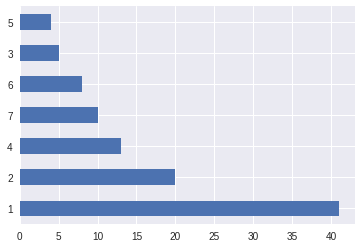

In [5]:
#3.Оцените сбалансированность данных по классам (постройте гистограмму)

%matplotlib inline
df['class_type'].value_counts().plot.barh()
pt.show()

In [6]:
#4.Выполните масштабирование количественных признаков

quantitative_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categories_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('quantitative: ', quantitative_columns)
print('categories: ', categories_columns)

quantitative:  ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type']
categories:  []


In [7]:
df['class_type'] = df['class_type'].apply(lambda x: str(x))

#заново выделим по категориям и количеству
quantitative_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categories_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('quantitative: ', quantitative_columns)
print('categories: ', categories_columns)

quantitative:  ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
categories:  ['class_type']


In [8]:
scaler = MinMaxScaler()
df[quantitative_columns] = scaler.fit_transform(df[quantitative_columns])

df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,1
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,1


In [9]:
#5.Выполните замену категориальных признаков

for i in categories_columns:
    print(i,': ', df[i].unique())

class_type :  ['1' '4' '2' '7' '6' '5' '3']


In [10]:
binary_columns = [i for i in categories_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categories_columns if len(df[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(101, 23)


,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7,hair,feathers,eggs,...,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
1,1,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0
2,0,0,0,1,0,0,0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
4,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0


In [11]:
#6.Оцените корреляцию между признаками и удалите те признаки, которые коррелируют с наибольшим числом других

df.head()

,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7,hair,feathers,eggs,...,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
1,1,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0
2,0,0,0,1,0,0,0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
4,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0


              class_type_1  class_type_2  class_type_3  class_type_4  \
class_type_1      1.000000     -0.410761     -0.188654     -0.317722   
class_type_2     -0.410761      1.000000     -0.113402     -0.190987   
class_type_3     -0.188654     -0.113402      1.000000     -0.087716   
class_type_4     -0.317722     -0.190987     -0.087716      1.000000   
class_type_5     -0.167865     -0.100906     -0.046344     -0.078050   
class_type_6     -0.242449     -0.145739     -0.066935     -0.112729   
class_type_7     -0.274028     -0.164722     -0.075653     -0.127412   
hair              0.878503     -0.427851     -0.196503     -0.330941   
feathers         -0.410761      1.000000     -0.113402     -0.190987   
eggs             -0.938848      0.419248      0.099944      0.324287   
milk              1.000000     -0.410761     -0.188654     -0.317722   
airborne         -0.366765      0.656553     -0.127412     -0.214581   
aquatic          -0.362613     -0.058552     -0.074542      0.51

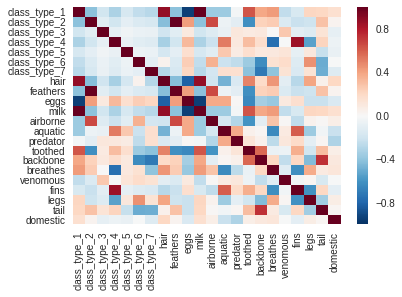

In [12]:
corr_matrix = df.drop(['catsize'], axis=1).corr()
sn.heatmap(corr_matrix);
print(corr_matrix)

In [13]:
#7.Заполните пропущенные значения в данных

# Пропущенных значений нет

In [14]:
#8.Решите поставленную задачу классификации в соответствии с заданием

# К соседей
X, y = df.drop('catsize', axis=1), df['catsize']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 5, 0.25)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

(70, 22)
(31, 22)
best train score: 0.7857142857142857 	 at radius: 1.25
test score:  0.741935483871


In [15]:
# Дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.8142857142857143 	 at features number: 7 	 at depth: 3
test score:  0.774193548387


In [16]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        
        General description. 
        Determines the probability that a test instance matching a class.
        
        Algorithm. 
        We'll go through the zero radius to the double classifier radius
        with the elementary step(dr). If an instance lies along the:
        * Zero raduis+dr - corresponds 100%
        * Classifier raduis+dr - corresponds 50%
        * Double classifier raduis+dr and beyond it - corresponds 0%
        There are intermediate values of percents. Each step corresponds
        to its own percentage value. If predicted instance changes its 
        class, this instance belongs to the current radius and it is 
        assigned the appropriate percentage. 
        
        fit method built-in
        '''
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),2), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

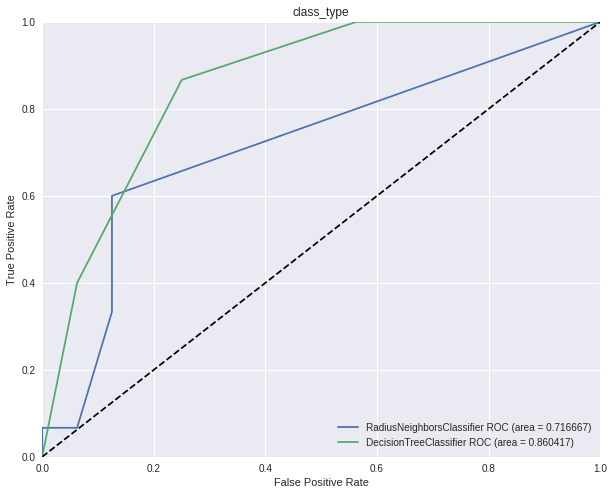

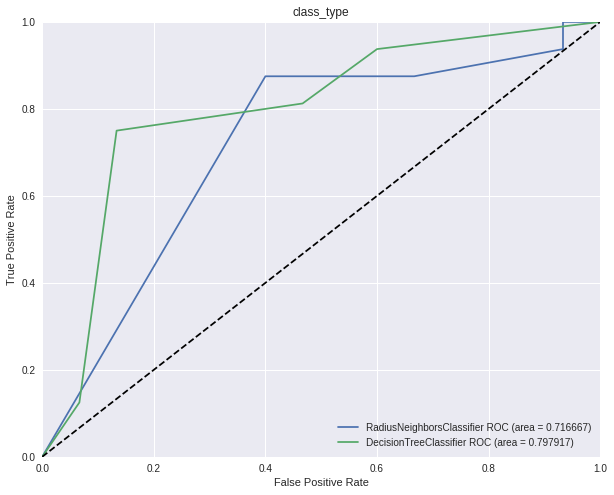

In [17]:
pt.figure(figsize=(10,8))
# K соседей
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test, probas_mrnc0[:,0])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

# решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,0])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

# вывод графика
pt.plot([0, 1], [0, 1], 'k--')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()


pt.figure(figsize=(10,8))
# K соседей
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, probas_mrnc1[:,1])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 
# решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_dtc1[:,1])
roc_auc  = auc(fpr, tpr)
pt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   
# вывод графика
pt.plot([0, 1], [0, 1], 'k--')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.xlabel('False Positive Rate')
pt.ylabel('True Positive Rate')
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()

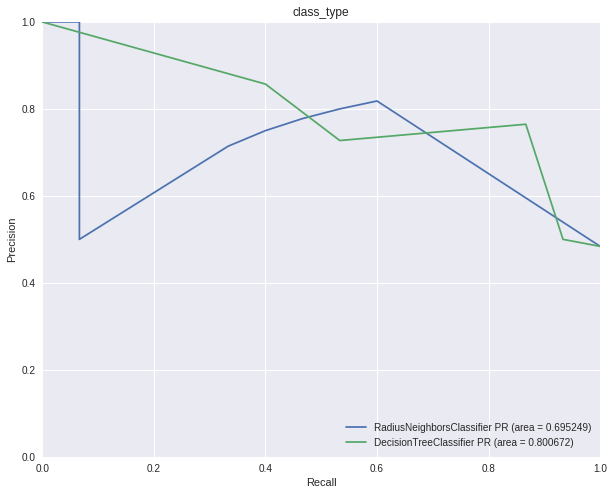

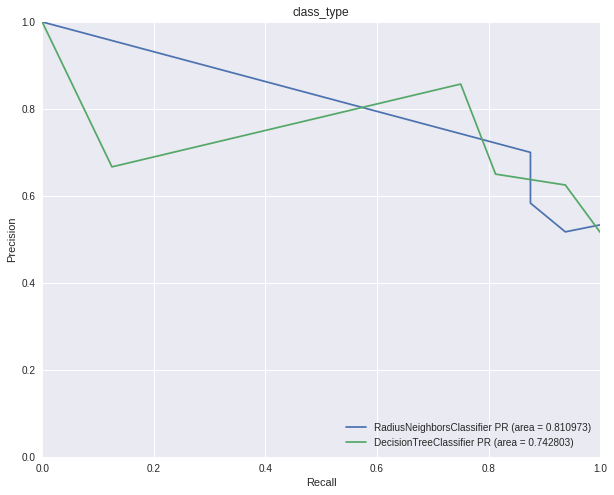

In [18]:
pt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K соседей
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_mrnc1[:,0])
aps_mrnc1 = average_precision_score(y_test_invers,probas_mrnc1[:,0])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
pt.xlabel('Recall')
pt.ylabel('Precision')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()


pt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test,probas_mrnc1[:,1])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
pt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
pt.xlabel('Recall')
pt.ylabel('Precision')
pt.xlim([0.0, 1.0])
pt.ylim([0.0, 1.0])
pt.legend(loc=4, fontsize='medium')
pt.title('class_type')
pt.show()

In [19]:
#9.Сравните кривые для классификаторов, указанных в задании, сделайте выводы

#Классификаторы дерево принятия решений и k ближайших соседей(по радиусу) имеют примерно одинаковые показатели 
#качества относительно PR и ROC кривых. В целом, данные классификаторы правильно решают задачу предсказания класса 
#с вероятностью 0.7~0.85, что не слишком точно, но и далеко от случайного - 0.5. 
#Поэтому задача классификации была решена, но по-прежнему есть пути улучшить результаты: 
#подобрать более подходящий под задачу классификатор, осуществить несколько иной подход 
#к подготовке данных в соответсвие с выбранным классификатором